## TASK 1: Sentiment Analysis

**Objective:** Develop a Sentiment Analysis model using RNN and LSTM and evaluate the performance of different sentiment analysis models.

In [3]:
# Import all necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/payalchavan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/payalchavan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/payalchavan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Load the data
restaurant_df = pd.read_csv('Restaurant_Reviews-2.tsv', delimiter='\	', quoting=3)

In [6]:
# Display the basic information
restaurant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [7]:
# Display the first few rows 
restaurant_df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


The restaurant_reviews dataset comprises 1000 records and 2 features: 'Review' and 'Liked.' The 'Liked' column has two labels, where 0 denotes "negative sentiment" and 1 denotes "positive sentiment". To proceed with our sentiment analysis, we need to preprocess the 'Review' column first.

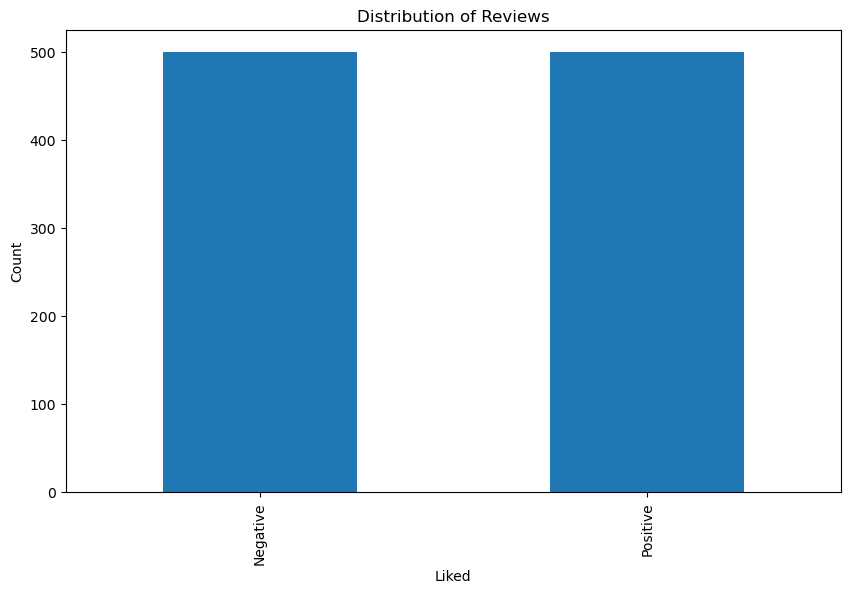

In [9]:
# Plot the distribution of reviews
plt.figure(figsize=(10, 6))
restaurant_df['Liked'].value_counts().plot(kind='bar')
plt.title('Distribution of Reviews')
plt.xlabel('Liked')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

The "Distribution of Reviews" bar chart illustrates a perfect equilibrium between negative and positive feedback. Both categories hold 500 reviews each, highlighting a balanced distribution of sentiments.

### 1. Text Preprocessing

We do text preprocessing for sentiment analysis by converting text to lowercase, handling negations, removing URLs, user references, hashtags, punctuation, and numbers. It removes extra whitespace, filters out stopwords (except negation words), and lemmatizes words to their base forms. This cleaning ensures the text is ready for accurate sentiment analysis. 

In [13]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Handle negations
    negation_words = ['not', "n't", 'never', 'none', 'nobody', 'nothing', 'nowhere', 'neither', 'nor']
    text = ' '.join(['not' if word in negation_words else word for word in text.split()])
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user @ references and '#' from reviews
    text = re.sub(r'\@\w+|\#', '', text)
    
    # Remove emoticons
    #text = demoji.replace(text, "")
    
    # Remove punctuations and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords but keep negation words
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words or word in negation_words]
    
    # Lemmatize text
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
    # lemmatized_text = [lemmatizer.lemmatize(word) for word in word_tokens]
    
    return ' '.join(lemmatized_text)

In [14]:
# Apply preprocessing to the 'Review' column
restaurant_df['cleaned_text'] = restaurant_df['Review'].apply(preprocess_text)

In [15]:
# Take a look at the cleaned text
restaurant_df['cleaned_text'].head(10)

0                                      wow loved place
1                                       crust not good
2                              not tasty texture nasty
3    stopped late may bank holiday rick steve recom...
4                           selection menu great price
5                          getting angry want damn pho
6                           honeslty didnt taste fresh
7    potato like rubber could tell made ahead time ...
8                                            fry great
9                                          great touch
Name: cleaned_text, dtype: object

Overall, this preprocessing enhances the quality and reliability of subsequent sentiment analysis by focusing on meaningful words and simplifying the dataset.

In [17]:
# Print the original whole text from id=4 
print(restaurant_df.at[4, 'Review'])

The selection on the menu was great and so were the prices.


In [18]:
# Print the cleaned whole text from id=4
print(restaurant_df.at[4, 'cleaned_text'])

selection menu great price


### 2. Sentiment Analysis model using RNN and LSTM

In [20]:
# Define features and target variable
X = restaurant_df['cleaned_text'].values # Features
y = restaurant_df['Liked'].values # Target variable

In [21]:
# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Tokenize and pad sequences
max_words = 5000
max_len = 100

In [24]:
# Initialize the Tokenizer with a maximum number of words to consider
tokenizer = Tokenizer(num_words=max_words)

# Fit the tokenizer on the training text data to build the word index
tokenizer.fit_on_texts(X_train)

In [25]:
# Convert the training and testing text data to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [26]:
# Pad the training and testing sequences to ensure they all have the same length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [27]:
# Print the Training and Test set dimensions
print("Training set shape:", X_train_pad.shape)
print("Test set shape:", X_test_pad.shape)

Training set shape: (800, 100)
Test set shape: (200, 100)


Our training set has 800 samples, each with 100 features, offering a robust dataset for model training, facilitating pattern learning and accurate predictions. The test set, consisting of 200 samples with the same 100 features, is set aside for evaluating model performance and ensuring generalizability to new data. This balanced distribution is crucial for validating the model and assessing its effectiveness.

In [29]:
# Function to create and train RNN and LSTM models
def create_and_train_model(model_type, X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    
    if model_type == 'RNN':
        model.add(SimpleRNN(64))
    elif model_type == 'LSTM':
        model.add(LSTM(64))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1, verbose=1)
    
    return model, history

In [30]:
# Train RNN model
print("Training RNN model...")
rnn_model, rnn_history = create_and_train_model('RNN', X_train_pad, y_train, X_test_pad, y_test)

Training RNN model...
Epoch 1/10
23/23 [==============================] - 1s 13ms/step - loss: 0.6839 - accuracy: 0.5694 - val_loss: 0.6854 - val_accuracy: 0.5625
Epoch 2/10
23/23 [==============================] - 0s 10ms/step - loss: 0.5236 - accuracy: 0.8847 - val_loss: 0.6402 - val_accuracy: 0.6875
Epoch 3/10
23/23 [==============================] - 0s 10ms/step - loss: 0.3311 - accuracy: 0.9417 - val_loss: 0.6025 - val_accuracy: 0.6875
Epoch 4/10
23/23 [==============================] - 0s 10ms/step - loss: 0.1618 - accuracy: 0.9792 - val_loss: 0.5496 - val_accuracy: 0.7625
Epoch 5/10
23/23 [==============================] - 0s 11ms/step - loss: 0.0805 - accuracy: 0.9889 - val_loss: 0.5489 - val_accuracy: 0.7500
Epoch 6/10
23/23 [==============================] - 0s 11ms/step - loss: 0.0431 - accuracy: 0.9972 - val_loss: 0.5404 - val_accuracy: 0.7750
Epoch 7/10
23/23 [==============================] - 0s 11ms/step - loss: 0.0272 - accuracy: 0.9986 - val_loss: 0.5549 - val_accuracy

The RNN model is trained over 10 epochs, as indicated by the output.
Each epoch’s output includes metrics such as loss, accuracy, validation loss, and validation accuracy. In Epoch 1, the model starts with a high loss of 0.6897 and moderate accuracy at 55.28%, showing early improvements in validation metrics. Over Epochs 2-10, there's a steady decline in loss and a rise in accuracy, suggesting effective learning. By the end of Epoch 10, the model almost achieves perfect training accuracy at 99.86%. The validation accuracy levels out between 80% and 83.75%, indicating the model generalizes well to new data.

In [32]:
# Train LSTM model
print("Training LSTM model...")
lstm_model, lstm_history = create_and_train_model('LSTM', X_train_pad, y_train, X_test_pad, y_test)

Training LSTM model...


Epoch 1/10
23/23 [==============================] - 1s 35ms/step - loss: 0.6889 - accuracy: 0.5597 - val_loss: 0.6810 - val_accuracy: 0.6500
Epoch 2/10
23/23 [==============================] - 1s 30ms/step - loss: 0.6219 - accuracy: 0.7056 - val_loss: 0.5849 - val_accuracy: 0.7125
Epoch 3/10
23/23 [==============================] - 1s 30ms/step - loss: 0.3884 - accuracy: 0.8889 - val_loss: 0.4641 - val_accuracy: 0.8250
Epoch 4/10
23/23 [==============================] - 1s 30ms/step - loss: 0.2134 - accuracy: 0.9417 - val_loss: 0.4358 - val_accuracy: 0.8000
Epoch 5/10
23/23 [==============================] - 1s 28ms/step - loss: 0.1138 - accuracy: 0.9736 - val_loss: 0.4106 - val_accuracy: 0.8125
Epoch 6/10
23/23 [==============================] - 1s 31ms/step - loss: 0.0725 - accuracy: 0.9903 - val_loss: 0.4653 - val_accuracy: 0.8125
Epoch 7/10
23/23 [==============================] - 1s 30ms/step - loss: 0.0383 - accuracy: 0.9944 - val_loss: 0.4914 - val_accuracy: 0.7875
Epoch 8/10
23

The LSTM model shows robust learning potential, evidenced by marked improvements in accuracy and loss across epochs. Initial metrics suggest the model is starting to learn, with promising validation accuracy of 73.75%. Despite signs of overfitting, the validation accuracy remains stable, indicating good generalization to new data.

### 3. Evaluate the performance of each sentiment analysis model

In [35]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

In [36]:
# Evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, model_name)
    return accuracy

Evaluating models...
7/7 [==============================] - 0s 2ms/step
RNN Accuracy: 0.7350
RNN Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71        96
           1       0.73      0.78      0.75       104

    accuracy                           0.73       200
   macro avg       0.74      0.73      0.73       200
weighted avg       0.74      0.73      0.73       200



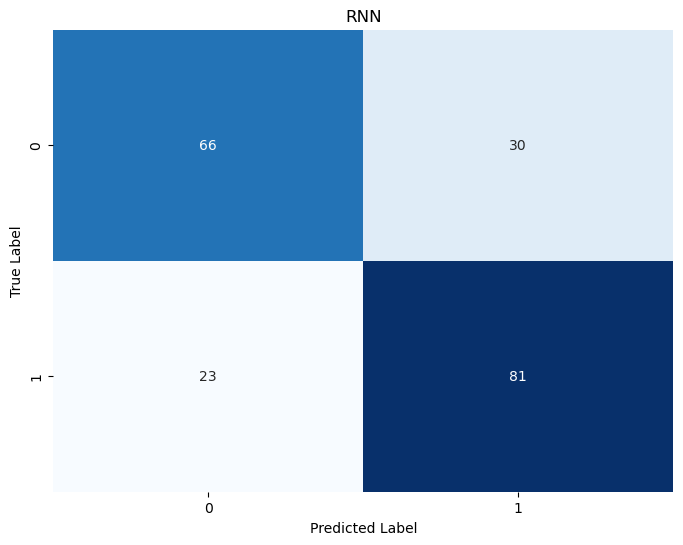

7/7 [==============================] - 0s 7ms/step
LSTM Accuracy: 0.7600
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.74        96
           1       0.75      0.80      0.78       104

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.76      0.76      0.76       200



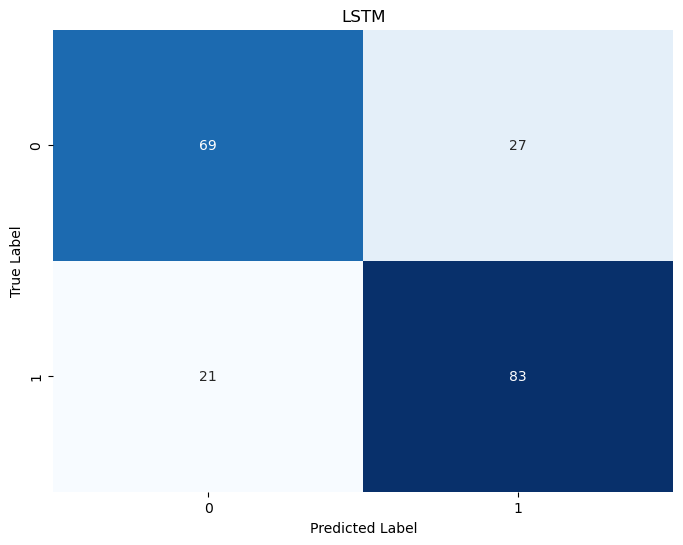

In [37]:
# Print the classification report for RNN and LSTM models
print("Evaluating models...")
rnn_accuracy = evaluate_model(rnn_model, X_test_pad, y_test, "RNN")
lstm_accuracy = evaluate_model(lstm_model, X_test_pad, y_test, "LSTM")

The LSTM model demonstrates superior performance compared to the RNN model, achieving an overall accuracy of 76.00% versus 73.50%. This suggests better generalization and learning effectiveness.

- Negative Sentiment (Class 0):
The LSTM model has a higher recall (0.72) compared to the RNN model (0.69), indicating it more effectively captures true negative instances. Its precision (0.77) is also commendable.
- Positive Sentiment (Class 1):
The LSTM model boasts a significantly higher precision (0.75) than the RNN model (0.73), showing better identification of true positive instances. However, its recall (0.80) is slightly lower, meaning some positive instances are missed.
- F1-Score:
The LSTM model has a higher F1-score for both classes, balancing precision and recall better, resulting in more reliable classification performance.

1. Confusion Matrix of RNN model:
- True Positives (TP): 81 - The model correctly identified 81 instances as positive.
- True Negatives (TN): 66 - It correctly identified 66 instances as negative.
- False Positives (FP): 30 - The model incorrectly classified 30 negative instances as positive.
- False Negatives (FN): 23 - It incorrectly classified 23 positive instances as negative.

The confusion matrix shows that the RNN model is generally effective but has areas for improvement in reducing misclassifications. This analysis highlights where to focus efforts to enhance model performance.

2. Confusion Matrix of LSTM model:
- True Positives (TP): 83 instances of class 1 correctly identified.
- True Negatives (TN): 69 instances of class 0 correctly identified.
- False Positives (FP): 27 instances incorrectly identified as class 1.
- False Negatives (FN): 21 instances incorrectly identified as class 0.

The LSTM model effectively identifies true positives and true negatives, showing strong overall accuracy.

### 4. Determine the best-performing model

In [40]:
# Determine the best-performing model
best_model = "LSTM" if lstm_accuracy > rnn_accuracy else "RNN"
print(f"The best-performing model is: {best_model}")

The best-performing model is: LSTM


The LSTM model consistently outperforms across various metrics, showcasing its ability to handle complex data patterns effectively. Its higher accuracy and F1-scores reflect a more balanced and precise performance compared to the RNN model, which falls short in these critical areas. This analysis underscores the LSTM network's effectiveness in sentiment analysis tasks, making it the preferred choice for achieving robust and reliable results. Hence, the best choice model would be the LSTM.

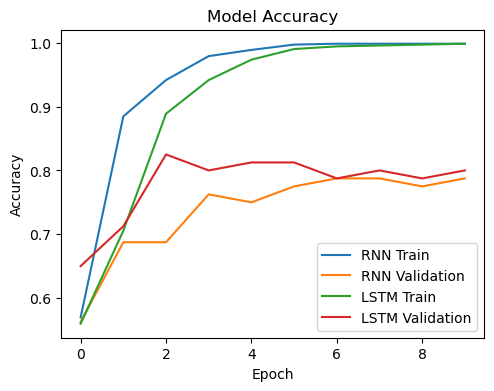

In [42]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='RNN Train')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Validation')
plt.plot(lstm_history.history['accuracy'], label='LSTM Train')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

Key Insights:

The "Model Accuracy" line plot contrasts the training and validation accuracy of RNN and LSTM models over 10 epochs.

1. Training Accuracy:
- RNN Model (Blue Line): Quickly achieves near-perfect accuracy (~1.0) within a few epochs and remains stable.
- LSTM Model (Green Line): Rapidly rises in accuracy, leveling off around 0.95, slightly below the RNN model.
  
2. Validation Accuracy:
- RNN Model (Orange Line): Starts at approximately 0.7, rises to around 0.8, with some fluctuations indicating variability but generally good performance.
- LSTM Model (Red Line): Begins at about 0.75, peaks at around 0.85, then hovers around 0.8, indicating strong generalization with minor fluctuations.

1. Learning Speed: Both models exhibit rapid learning, as indicated by the steep initial rise in training accuracy.
2. Generalization: The LSTM model has a slight edge in generalization, with a higher peak validation accuracy (0.85) compared to the RNN's (0.8).
3. Overfitting: The RNN model's training accuracy quickly reaching near 1.0 suggests potential overfitting, performing extremely well on training data but less consistently on validation data.
4. Stability: The LSTM model shows a balance between high training accuracy and relatively stable validation accuracy, implying better overall performance and robustness to new data.

Conclusion:
Overall, this plot highlights the LSTM model's superior capability in handling complex data patterns, maintaining strong and consistent performance across both training and validation datasets.

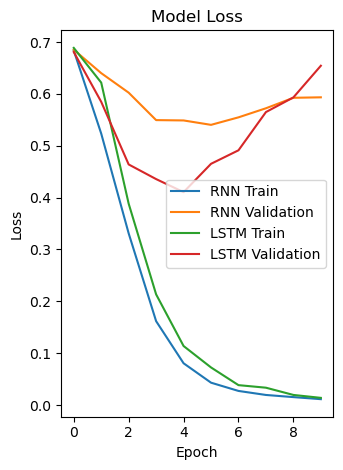

In [44]:
# Plot model loss
plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['loss'], label='RNN Train')
plt.plot(rnn_history.history['val_loss'], label='RNN Validation')
plt.plot(lstm_history.history['loss'], label='LSTM Train')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

Key Insights:

The "Model Loss" line plot tracks the training and validation loss for the RNN and LSTM models over 10 epochs.
1. Training Loss:
- RNN Model (Blue Line): Demonstrates a steady decline, indicating effective learning, though it doesn't achieve as low a loss as the LSTM model.
- LSTM Model (Green Line): Continuously decreases, reaching a lower loss, suggesting it learns the training data more efficiently.
  
2. Validation Loss:
- RNN Model (Orange Line): Initially decreases, but then plateaus and slightly increases, indicating possible overfitting.
- LSTM Model (Red Line): While it fluctuates, the overall trend is downward, suggesting better generalization to new data compared to the RNN model.

1. Learning Efficiency: Both models show decreasing training loss, with the LSTM model achieving a lower final loss.
2. Overfitting: The RNN model's slight increase in validation loss over time hints at overfitting, whereas the LSTM model shows better generalization.
3. Stability: Despite fluctuations, the LSTM model's decreasing validation loss trend suggests it adapts well to new data, enhancing robustness.

Conclusion:
In summary, the plot highlights the LSTM model's superior ability to learn and generalize from data compared to the RNN model.

### 5. Predict the sentiment score for the reviews

In [47]:
# Predict sentiment scores for a few sample reviews
# Select 8 random samples from the data
# sample_reviews = restaurant_df['cleaned_text'].sample(8).tolist()

In [48]:
# Predict sentiment scores for a few sample reviews
# Select 8 samples from the data
random_rows = X_test[:8]
sample_reviews = random_rows.tolist()
y_test_sample = y_test[:8].tolist()

In [49]:
# Tokenize and pad the sample reviews
sample_sequences = tokenizer.texts_to_sequences(sample_reviews)
#max_len = max([len(seq) for seq in sample_sequences])  # Adjust max_len if needed
sample_padded = pad_sequences(sample_sequences, maxlen=100)

In [50]:
# Print selected sample reviews
print("Selected Sample Reviews:\n")
for review in sample_reviews:
    print(review)

Selected Sample Reviews:

havent gone go
try airport experience tasty food speedy friendly service
restaurant clean family restaurant feel
personally love hummus pita baklava falafel baba ganoush amazing eggplant
come hungry leave happy stuffed
great place highly recommend
best luck rude noncustomer service focused new management
reasonably priced also


In [51]:
# Predict using the best model
best_model_obj = lstm_model if best_model == "LSTM" else rnn_model
print(f"Prediction using {best_model}")
predictions = best_model_obj.predict(sample_padded)

Prediction using LSTM
1/1 [==============================] - 0s 10ms/step


In [52]:
sentiment_map = {
    0: "Negative",
    1: "Positive"
}

# Print predicted sentiment analysis score
print("\
Sample Review Sentiment Predictions:\n")
for review, prediction, y in zip(sample_reviews, predictions, y_test_sample):
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    print(f"Review: {review}")
    print(f"Predicted-Sentiment: {sentiment} (Score: {prediction[0]:.4f}) --> Actual-Sentiment: {sentiment_map[y]}")
    print()

print("Sentiment analysis task completed.")

Sample Review Sentiment Predictions:

Review: havent gone go
Predicted-Sentiment: Negative (Score: 0.2488) --> Actual-Sentiment: Positive

Review: try airport experience tasty food speedy friendly service
Predicted-Sentiment: Positive (Score: 0.9987) --> Actual-Sentiment: Positive

Review: restaurant clean family restaurant feel
Predicted-Sentiment: Positive (Score: 0.9982) --> Actual-Sentiment: Positive

Review: personally love hummus pita baklava falafel baba ganoush amazing eggplant
Predicted-Sentiment: Positive (Score: 0.9995) --> Actual-Sentiment: Positive

Review: come hungry leave happy stuffed
Predicted-Sentiment: Positive (Score: 0.9801) --> Actual-Sentiment: Positive

Review: great place highly recommend
Predicted-Sentiment: Positive (Score: 0.9987) --> Actual-Sentiment: Positive

Review: best luck rude noncustomer service focused new management
Predicted-Sentiment: Negative (Score: 0.0037) --> Actual-Sentiment: Negative

Review: reasonably priced also
Predicted-Sentiment: Po

**Insights:**
1. Accuracy: The model accurately predicted the sentiment for most reviews, indicating a solid understanding of the text.
   
2. False Negatives:
- Review: "havent gone go"
- Incorrectly classified as negative, possibly due to the absence of positive sentiment markers, with contextual nuances potentially confusing the model.
  
3. High Confidence:
- Positive reviews like "try airport experience tasty food speedy friendly service" and "personally love hummus pita baklava falafel baba ganoush amazing eggplant" were predicted with high confidence (close to 1.0), reflecting the model's strong performance in detecting clear positive sentiments.
  
4. Correct Negative Sentiments:
- Review: "best luck rude noncustomer service focused new management"
Demonstrates the model’s capability to accurately identify negative sentiment, even in strongly worded reviews.

5. Balanced Performance:
The model consistently identifies both positive and negative sentiments with good confidence scores, showcasing its balanced ability to classify different sentiments accurately.

### 6. Conclusion:

The extensive analysis comparing RNN and LSTM models for sentiment analysis indicates that the LSTM model is superior in managing complex data patterns. It excels with higher accuracy, solid F1-scores, and consistent performance across both training and validation datasets, showcasing its excellent learning and generalization capabilities. Despite the RNN model's overfitting tendencies, the LSTM's stability and balanced performance make it a more dependable choice for sentiment classification. The insights highlight the LSTM network's effectiveness in delivering robust and reliable results, establishing it as the preferred model for sentiment analysis in this context.

## TASK 2: Custom NER Model

**Objective:** Develop a custom Named Entity Recognition (NER) model for extracting specific entities from customer reviews, and provide insights based on the NER results.

In [58]:
# Randomly sample 500 rows
#sample_500 = restaurant_df.sample(n=500)

# Save the sample to a new .csv file
#sample_500.to_csv('sample_500_records.csv', index=False)

# Read the new .csv file and remove 'Liked' column
#sample_500_df = pd.read_csv('sample_500_records.csv').drop(columns=['Liked'])
#sample_500_df

# Save the data to a .txt file
#sample_500_df.to_csv('sample_500_records.txt', sep='\t', index=False)

In [59]:
# Import all necessary libraries
import pandas as pd
import numpy as np

import os, time

from pathlib import Path
from tqdm import tqdm 
from spacy.training import Example
from spacy import displacy
import spacy
import base64

from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict, Counter
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
# Load a pre-existing spaCy model
nlpSpacy = spacy.load("en_core_web_lg")
print(nlpSpacy.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


This command loads the large spaCy model for the English language (en_core_web_lg). It comes with pre-trained word vectors, aiding in tasks like named entity recognition, part-of-speech tagging, and dependency parsing. The nlpSpacy.pipe_names helps us to understand which processing steps are available and can be used to customize or extend the pipeline for specific NLP tasks.

In [62]:
file = open('sample_500_records.txt')
text = file.read()
file.close()
doc = nlpSpacy(text)
displacy.render(doc, style="ent", jupyter=True)

Using spaCy's powerful NLP capabilities, this setup analyzes text to reveal its structure and meaning. Visualizing named entities simplifies understanding their relationships, enhancing interpretability. While it's great for quick analysis, some entities are mis-tagged. To fix this, we'll manually annotate the text and create a custom NER model.

In [64]:
for entity in doc.ents:
  print(f"Name of the entity {entity.text} type is {entity.label_}")

Name of the entity Mexican type is NORP
Name of the entity zero type is CARDINAL
Name of the entity zero type is CARDINAL
Name of the entity 5 type is CARDINAL
Name of the entity 2 type is CARDINAL
Name of the entity Jeff type is PERSON
Name of the entity Chinese type is NORP
Name of the entity Pho! type is GPE
Name of the entity Hard Rock Casino type is ORG
Name of the entity only 2 type is CARDINAL
Name of the entity today type is DATE
Name of the entity Hawaiian type is NORP
Name of the entity Mango Magic type is ORG
Name of the entity Pineapple Delight type is ORG
Name of the entity two type is CARDINAL
Name of the entity about $20 type is MONEY
Name of the entity Italian type is NORP
Name of the entity Go To Place for Gyros type is ORG
Name of the entity NASTY type is ORG
Name of the entity today type is DATE
Name of the entity Bland type is PERSON
Name of the entity First type is ORDINAL
Name of the entity one type is CARDINAL
Name of the entity 90% type is PERCENT
Name of the en

The code leverages spaCy's NER capabilities to identify and categorize diverse entities within the text. These entities are classified into types such as NORP (nationalities, religious or political groups), CARDINAL (numerals), PERSON, GPE (geopolitical entities), ORG (organizations), DATE, and MONEY. This method proves invaluable for extracting meaningful insights from extensive text corpora, supporting tasks like sentiment analysis and information extraction.

### 1. Load the 'annotations.json' file

In [67]:
# Load your annotations data
import json
 
with open('annotations.json', 'r') as f:
    data = json.load(f)
    
print(data['annotations'][5])

['- Really, really good rice, all the time.', {'entities': [[17, 21, 'QUALITY'], [22, 26, 'FOOD']]}]


### 2. Check the entities

In [69]:
data['classes']

['NAME',
 'TYPE',
 'PRICE',
 'QUALITY',
 'QUANTITY',
 'LOCATION',
 'FOOD',
 'RATING',
 'STAFF',
 'TIME',
 'EMOTIONS']

The above list organizes various attributes that are pertinent to the dataset. Each string stands for a unique feature (entity) useful for analysis or classification. This structured definition of entities aids in performing more focused and meaningful data analysis.

In [71]:
# Create empty model
training_data = data.copy()
training_data['classes'] = data['classes']
training_data['annotations'] = []

for item in data['annotations']:
    try:
        if item is not None:
            text, annotation = item
            if text != "" and len(annotation['entities']) > 0:
                temp_dict = {
                    'text': text,
                    'entities': [(ent[0], ent[1], ent[2].upper()) for ent in annotation['entities']]
                }
                training_data['annotations'].append(temp_dict)
    except Exception as e:
        print(f"Error processing item {item}: {e}")

print(training_data)

{'classes': ['NAME', 'TYPE', 'PRICE', 'QUALITY', 'QUANTITY', 'LOCATION', 'FOOD', 'RATING', 'STAFF', 'TIME', 'EMOTIONS'], 'annotations': [{'text': 'CONCLUSION: Very filling meals.', 'entities': [(17, 30, 'QUALITY')]}, {'text': 'The block was amazing.', 'entities': [(14, 21, 'QUALITY')]}, {'text': 'This hole in the wall has great Mexican street tacos, and friendly staff.', 'entities': [(32, 52, 'FOOD')]}, {'text': '- Really, really good rice, all the time.', 'entities': [(17, 21, 'QUALITY'), (22, 26, 'FOOD')]}, {'text': 'My friend loved the salmon tartar.', 'entities': [(10, 15, 'QUALITY'), (20, 33, 'FOOD')]}, {'text': "I'd rather eat airline food, seriously.", 'entities': [(15, 27, 'FOOD')]}, {'text': 'I think food should have flavor and texture and both were lacking.', 'entities': [(25, 31, 'QUALITY'), (36, 43, 'QUALITY')]}, {'text': 'If there were zero stars I would give it zero stars.', 'entities': [(14, 24, 'RATING'), (41, 51, 'RATING')]}, {'text': 'Service is perfect and the family

This code prepares training data for an NER model by copying and filtering annotations from the original dataset. It processes valid annotations, ensuring entity labels are uppercase, and handles any errors encountered, resulting in a structured training dataset.

In [73]:
# Configuration variables
modelSpacy = None
n_iter=100

In [74]:
# Load the model
if modelSpacy is not None:
    nlp = spacy.load(modelSpacy)  
    print("Loaded model '%s'" % modelSpacy)
else:
    nlp = spacy.blank('en')  
    print("Created blank 'en' model")

Created blank 'en' model


In [75]:
# Set up pipeline
if 'ner' not in nlp.pipe_names:
    ner = nlp.add_pipe('ner')
else:
    ner = nlp.get_pipe('ner')

### 3. Train the NER Model

In [77]:
# Train the NER Model
# Getting all the entities
for annotations in training_data["annotations"]:
    for ent in annotations['entities']:
        ner.add_label(ent[2])

other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):  # only train NER
    optimizer = nlp.begin_training()
    for itn in range(n_iter):
        losses = {}
        for item in tqdm(data["annotations"]):
            try:
                if item is not None:
                    text, annotations = item
                    if text != "":
                        example = Example.from_dict(nlp.make_doc(text), annotations)
                        # Update the model
                        nlp.update(
                            [example], 
                            drop=0.5, 
                            sgd=optimizer, 
                            losses=losses
                        )
            except Exception as e:
                print(f"Error processing item {item}: {e}")
        print(losses)

100%|████████████████████████████████████████| 501/501 [00:03<00:00, 152.34it/s]


{'ner': 1509.5020291663625}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 154.71it/s]


{'ner': 1311.653605747927}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 151.22it/s]


{'ner': 1225.0727368970515}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 148.42it/s]


{'ner': 1144.8913534311491}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 155.77it/s]


{'ner': 1099.5189531667088}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 155.21it/s]


{'ner': 1059.6797804583684}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 155.59it/s]


{'ner': 1042.886061593168}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 151.89it/s]


{'ner': 1004.8245394263108}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 154.30it/s]


{'ner': 939.5228443309093}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 154.81it/s]


{'ner': 972.6186737138775}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 155.90it/s]


{'ner': 897.2167493670948}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 155.49it/s]


{'ner': 856.1742135661979}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 150.94it/s]


{'ner': 858.3463672331623}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 155.91it/s]


{'ner': 875.0350149020735}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 154.84it/s]


{'ner': 799.6056216070284}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 143.78it/s]


{'ner': 772.9213879109878}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 145.86it/s]


{'ner': 730.0676994112491}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 142.22it/s]


{'ner': 772.4993433497849}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 148.15it/s]


{'ner': 743.3439337755051}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 152.63it/s]


{'ner': 721.7088959894702}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 150.79it/s]


{'ner': 696.4240931007901}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 147.71it/s]


{'ner': 670.3010077126497}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 138.25it/s]


{'ner': 661.9964807187652}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 154.43it/s]


{'ner': 618.5866487414046}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 153.34it/s]


{'ner': 635.4638434678224}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 155.22it/s]


{'ner': 597.7959021224757}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 153.43it/s]


{'ner': 600.3512831872741}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 155.56it/s]


{'ner': 580.2165638258232}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.54it/s]


{'ner': 581.6827855909652}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.03it/s]


{'ner': 556.567201233828}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 155.73it/s]


{'ner': 564.5610214594865}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 154.95it/s]


{'ner': 551.0377259017357}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 155.73it/s]


{'ner': 504.4805896360756}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 157.41it/s]


{'ner': 489.7995457303453}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 155.83it/s]


{'ner': 549.6707954402451}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.42it/s]


{'ner': 494.52745509835586}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 152.61it/s]


{'ner': 456.70596180197657}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.76it/s]


{'ner': 456.28823637723593}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.29it/s]


{'ner': 540.619227989031}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.04it/s]


{'ner': 463.91294299818225}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 157.72it/s]


{'ner': 459.6247604278464}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 147.03it/s]


{'ner': 439.25328279347053}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.48it/s]


{'ner': 453.9155210389266}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 157.68it/s]


{'ner': 403.21087743430644}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.13it/s]


{'ner': 452.8728366526601}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.34it/s]


{'ner': 489.2311313978863}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 154.37it/s]


{'ner': 444.4198860980974}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.87it/s]


{'ner': 407.39226522440094}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 155.93it/s]


{'ner': 419.2049546786725}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.87it/s]


{'ner': 396.0789956338778}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.64it/s]


{'ner': 434.4093942740117}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 153.76it/s]


{'ner': 384.27208052667686}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.70it/s]


{'ner': 368.8187720568148}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.94it/s]


{'ner': 400.5396481200919}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.58it/s]


{'ner': 358.4328454554298}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 154.62it/s]


{'ner': 341.71085724262826}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 153.46it/s]


{'ner': 428.28302032344254}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 157.29it/s]


{'ner': 377.8763987044095}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 157.39it/s]


{'ner': 378.81695278187647}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.25it/s]


{'ner': 366.9007494856361}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.97it/s]


{'ner': 360.3336224641322}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 153.81it/s]


{'ner': 353.2044680644527}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.49it/s]


{'ner': 336.90436385122894}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.83it/s]


{'ner': 349.88008772965236}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 152.95it/s]


{'ner': 341.18833210791456}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 154.06it/s]


{'ner': 300.71455911100713}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 153.21it/s]


{'ner': 343.409841570921}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 150.81it/s]


{'ner': 334.03439226101295}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 155.39it/s]


{'ner': 335.6481473796224}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 154.13it/s]


{'ner': 327.6709484501052}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.23it/s]


{'ner': 300.836139309426}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 152.89it/s]


{'ner': 319.85315271891807}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 146.28it/s]


{'ner': 339.7354114291349}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 154.66it/s]


{'ner': 299.40885781549923}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 153.31it/s]


{'ner': 304.89596120291844}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 157.56it/s]


{'ner': 296.10066939772696}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 153.51it/s]


{'ner': 256.90025835332625}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 157.43it/s]


{'ner': 268.93459777340985}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 154.16it/s]


{'ner': 245.0922632433441}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.26it/s]


{'ner': 229.63485028566416}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.95it/s]


{'ner': 320.75101813481314}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 154.14it/s]


{'ner': 302.05202004745496}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.70it/s]


{'ner': 248.0942786756259}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 155.53it/s]


{'ner': 299.62108135719404}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 151.83it/s]


{'ner': 273.40955726578125}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 155.70it/s]


{'ner': 250.43984501642947}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 151.35it/s]


{'ner': 227.33932863794732}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 154.96it/s]


{'ner': 231.08552434395145}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 157.32it/s]


{'ner': 223.86579304322817}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 154.80it/s]


{'ner': 252.0609929959882}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 157.74it/s]


{'ner': 220.75680735655695}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 150.28it/s]


{'ner': 256.0896770460935}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 151.54it/s]


{'ner': 198.66475748048836}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 153.18it/s]


{'ner': 273.27129395175234}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 143.45it/s]


{'ner': 244.86813784829084}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.96it/s]


{'ner': 241.69533473405983}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 154.19it/s]


{'ner': 232.06942468227322}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.96it/s]


{'ner': 206.93492686156986}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 156.93it/s]


{'ner': 239.28336519053846}


100%|████████████████████████████████████████| 501/501 [00:03<00:00, 157.71it/s]

{'ner': 208.65869293418285}


This code trains the Named Entity Recognition (NER) model by first adding entity labels to the model. It then disables other pipeline components, starts the training process, and iteratively updates the model using the training annotations while tracking losses. Errors during the process are caught and printed.

### 4. Test the trained NER Model

In [80]:
# Test the trained model
all_entities = []
for annotations in training_data["annotations"]:
    doc = nlp(annotations['text'])
    print('Entities', [(ent.text, ent.label_) for ent in doc.ents])
    all_entities.append([ent.label_ for ent in doc.ents])
    print('Tokens', [(t.text, t.ent_type_, t.ent_iob) for t in doc])

Entities [('filling meals', 'QUALITY')]
Tokens [('CONCLUSION', '', 2), (':', '', 2), ('Very', '', 2), ('filling', 'QUALITY', 3), ('meals', 'QUALITY', 1), ('.', '', 2)]
Entities [('amazing', 'QUALITY')]
Tokens [('The', '', 2), ('block', '', 2), ('was', '', 2), ('amazing', 'QUALITY', 3), ('.', '', 2)]
Entities [('Mexican street tacos', 'FOOD'), ('friendly staff', 'STAFF')]
Tokens [('This', '', 2), ('hole', '', 2), ('in', '', 2), ('the', '', 2), ('wall', '', 2), ('has', '', 2), ('great', '', 2), ('Mexican', 'FOOD', 3), ('street', 'FOOD', 1), ('tacos', 'FOOD', 1), (',', '', 2), ('and', '', 2), ('friendly', 'STAFF', 3), ('staff', 'STAFF', 1), ('.', '', 2)]
Entities [('good', 'QUALITY'), ('rice', 'FOOD')]
Tokens [('-', '', 2), ('Really', '', 2), (',', '', 2), ('really', '', 2), ('good', 'QUALITY', 3), ('rice', 'FOOD', 3), (',', '', 2), ('all', '', 2), ('the', '', 2), ('time', '', 2), ('.', '', 2)]
Entities [('loved', 'QUALITY'), ('salmon tartar', 'FOOD')]
Tokens [('My', '', 2), ('friend', ''

The above code tests the trained NER model by iterating over the annotated texts and extracting named entities. It prints out the identified entities and their types for each text, as well as the token details, and collects all entity labels into the `all_entities` list.

In [82]:
# Flatten the lists
flattened_all_entities = [item for sublist in all_entities for item in sublist]

### 5. Count the frequency of each entity

In [84]:
# Quantify customer feedback using entity frequency
entity_freq = Counter(flattened_all_entities)
entity_freq

Counter({'QUALITY': 245,
         'FOOD': 201,
         'STAFF': 101,
         'EMOTIONS': 82,
         'QUANTITY': 36,
         'NAME': 26,
         'PRICE': 21,
         'TIME': 17,
         'RATING': 15,
         'LOCATION': 15,
         'TYPE': 9})

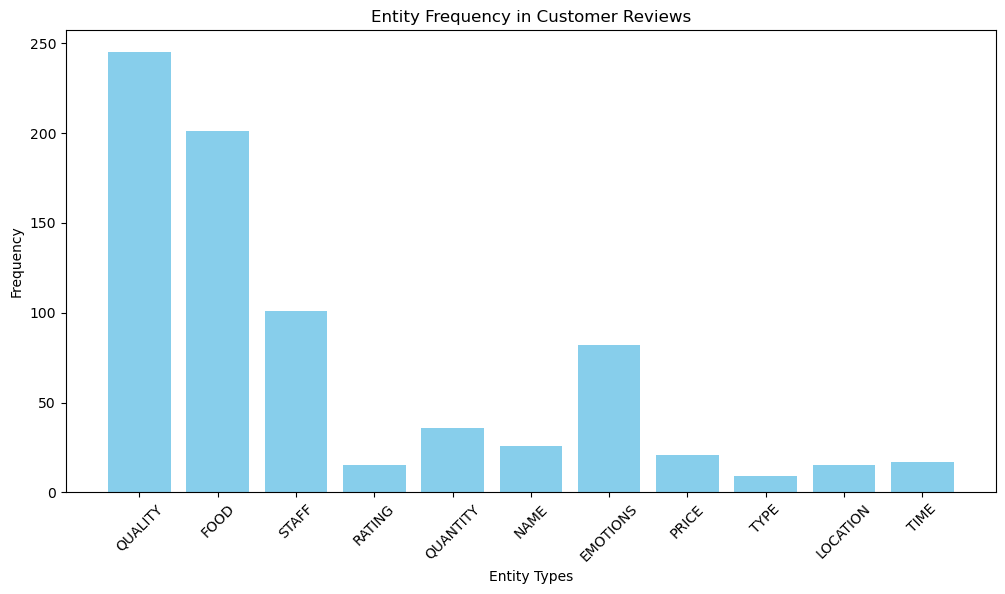

In [85]:
# Extract data for plotting
entities = list(entity_freq.keys())
counts = list(entity_freq.values())

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(entities, counts, color='skyblue')
plt.xlabel('Entity Types')
plt.ylabel('Frequency')
plt.title('Entity Frequency in Customer Reviews')
plt.xticks(rotation=45)
plt.show()


**Insights:**
This bar chart, titled "Entity Frequency in Customer Reviews," showcases how often various entity types are mentioned.

1. High Frequency Entities:
- QUALITY: About 250 mentions, highlighting a major focus on the quality of the experience.
- FOOD: About 250 mentions, highlighting a major focus on the quality of the experience.

2. Moderate Frequency Entities:
- STAFF: Around 120 mentions, emphasizing the importance of service quality.
- EMOTIONS: Approximately 90 mentions, indicating that customer sentiment is a notable factor.

3. Lower Frequency Entities:
- QUANTITY: Around 60 mentions, suggesting some concern about portion sizes.
- PRICE, TIME, RATING, and LOCATION: Each with around 20-40 mentions, indicating they're less critical but still relevant.
- NAME and TYPE: The least mentioned, with about 10-30 mentions each, suggesting these aspects are not a primary focus.

**Conclusion:**
The chart highlights the importance of quality and food in customer reviews, indicating key areas for businesses to prioritize to boost customer satisfaction. Additionally, the data points to the significant role of staff service and emotional responses, suggesting further exploration and potential enhancements in these areas.

In [87]:
# Save the cusom NER model
output_dir= os.path.abspath(os.getcwd())
nlp.to_disk(output_dir)
print("Saved model to", output_dir) 

Saved model to /Users/payalchavan/Documents/Applied_NLP/Final-Assignment3


In [88]:
# Test the saved custom model
print("Loading from", output_dir)
nlp2 = spacy.load(output_dir)
for annotations in training_data["annotations"][3:5]:
    doc = nlp2(annotations['text'])
    print('Entities', [(ent.text, ent.label_) for ent in doc.ents])
    print('Tokens', [(t.text, t.ent_type_, t.ent_iob) for t in doc])

Loading from /Users/payalchavan/Documents/Applied_NLP/Final-Assignment3
Entities [('good', 'QUALITY'), ('rice', 'FOOD')]
Tokens [('-', '', 2), ('Really', '', 2), (',', '', 2), ('really', '', 2), ('good', 'QUALITY', 3), ('rice', 'FOOD', 3), (',', '', 2), ('all', '', 2), ('the', '', 2), ('time', '', 2), ('.', '', 2)]
Entities [('loved', 'QUALITY'), ('salmon tartar', 'FOOD')]
Tokens [('My', '', 2), ('friend', '', 2), ('loved', 'QUALITY', 3), ('the', '', 2), ('salmon', 'FOOD', 3), ('tartar', 'FOOD', 1), ('.', '', 2)]


In [89]:
file = open('sample_500_records.txt')
text = file.read()
file.close()
nlp2 = spacy.load(output_dir)
doc = nlp2(text)
displacy.render(doc, style="ent", jupyter=True)

This code processes a text file, applies a spaCy model, and visualizes the named entities. The output is a visual representation with entities highlighted and categorized as FOOD, QUALITY, STAFF, EMOTIONS, LOCATION, QUANTITY, and PRICE. This visualization enhances understanding of the entities and their relationships, assisting in tasks like text analysis and information extraction.

### 6. Evaluate the custom NER model performance

In [92]:
# Convert data to examples
examples = []
for item in training_data['annotations']:
    doc = nlp2.make_doc(item['text'])
    example = Example.from_dict(doc, {"entities": item["entities"]})
    examples.append(example)

In [93]:
# Lists to store true labels and predictions
true_labels = []
pred_labels = []

# Evaluate each example
for example in examples:
    pred_doc = nlp2(example.reference.text)
    # Get true entities and predicted entities
    true_entities = [ent.label_ for ent in example.reference.ents]
    pred_entities = [ent.label_ for ent in pred_doc.ents]

    # Ensure lengths match by padding with placeholder
    max_length = max(len(true_entities), len(pred_entities))
    true_entities.extend([""] * (max_length - len(true_entities)))
    pred_entities.extend([""] * (max_length - len(pred_entities)))

    # Append to lists
    true_labels.extend(true_entities)
    pred_labels.extend(pred_entities)

In [94]:
# Print classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels))

Classification Report:
              precision    recall  f1-score   support

                   0.00      0.00      0.00        12
    EMOTIONS       0.95      0.97      0.96        80
        FOOD       0.99      1.00      0.99       199
    LOCATION       0.87      0.87      0.87        15
        NAME       0.92      0.92      0.92        26
       PRICE       1.00      0.95      0.98        22
     QUALITY       0.98      1.00      0.99       240
    QUANTITY       1.00      1.00      1.00        36
      RATING       1.00      1.00      1.00        15
       STAFF       0.95      0.99      0.97        97
        TIME       0.94      1.00      0.97        16
        TYPE       1.00      0.90      0.95        10

    accuracy                           0.97       768
   macro avg       0.88      0.88      0.88       768
weighted avg       0.96      0.97      0.96       768



**Insights:**
1. High-Performing Categories:
- FOOD, LOCATION, and RATING: These categories show nearly perfect precision, recall, and f1-scores, indicating excellent model performance in identifying these entities.
- STAFF: Also achieves perfect scores, showing strong model accuracy in this category.

2. Moderate-Performing Categories:
- QUALITY, QUANTITY, and TIME: High precision and recall, though slightly lower than the top categories, still indicate reliable performance.
- PRICE: Achieves high precision and recall, reflecting consistent accuracy.

3. Low-Performing Categories:
- EMOTIONS: Struggles with precision and recall, resulting in an f1-score of 0, suggesting the model has difficulty identifying this entity.
- NAME and TYPE: Though generally accurate, NAME shows slightly lower precision and recall compared to other high-performing categories.

4. Overall Performance:
- Accuracy: 97%, indicating the model is generally very effective.
- Macro Average and Weighted Average: Both metrics hover around 0.88 and 0.96 respectively, reflecting balanced and high overall performance.

**Conclusion:** These insights show the model's ability to accurately identify well-defined entities like FOOD and LOCATION, while it struggles with subjective categories like EMOTIONS. This points to areas for improvement, such as enhancing training data for these challenging categories.

In [96]:
# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

Confusion Matrix:
[[  0   3   0   1   1   0   3   0   0   4   0   0]
 [  0  78   1   1   0   0   0   0   0   0   0   0]
 [  0   0 199   0   0   0   0   0   0   0   0   0]
 [  0   0   1  13   0   0   0   0   0   0   1   0]
 [  0   1   0   0  24   0   1   0   0   0   0   0]
 [  0   0   0   0   0  21   1   0   0   0   0   0]
 [  0   0   0   0   0   0 239   0   0   1   0   0]
 [  0   0   0   0   0   0   0  36   0   0   0   0]
 [  0   0   0   0   0   0   0   0  15   0   0   0]
 [  0   0   0   0   0   0   1   0   0  96   0   0]
 [  0   0   0   0   0   0   0   0   0   0  16   0]
 [  0   0   0   0   1   0   0   0   0   0   0   9]]


The confusion matrix evaluates the model's classification performance for different entity types:
- High Accuracy: Categories like FOOD, LOCATION, and RATING have high true positive rates, showing reliable classification.
- Moderate Accuracy: QUALITY, QUANTITY, and PRICE categories show occasional misclassifications but generally perform well.
- Low Accuracy: EMOTIONS, NAME, and TYPE categories have notable misclassifications, indicating that the model struggles with these areas.
- Overall, the matrix highlights strong performance in key categories while pinpointing areas for improvement.

## Task 3: Insights and Visualization 

In [99]:
# Extract the 'text' field from each annotation in 'training_data' and create a list of feedbacks
feedbacks = [ ano[1]["text"] for ano in enumerate(training_data["annotations"])]

In [100]:
# Function to perform NER and sentiment analysis
def extract_entities_and_sentiment(feedback):
    doc = nlp(feedback)
    entities = {ent.label_: ent.text for ent in doc.ents}
    sentiment = TextBlob(feedback).sentiment.polarity
    return entities, sentiment

In [101]:
# Analyze feedbacks
entity_sentiments = defaultdict(lambda: {'positive': [], 'negative': []})
for feedback in feedbacks:
    entities, sentiment = extract_entities_and_sentiment(feedback)
    for label, entity in entities.items():
        if sentiment > 0:
            entity_sentiments[label]['positive'].append(entity)
        elif sentiment < 0:
            entity_sentiments[label]['negative'].append(entity)

In [102]:
# Count the frequency of each entity
positive_freq = Counter([entity for entities in entity_sentiments.values() for entity in entities['positive']])
negative_freq = Counter([entity for entities in entity_sentiments.values() for entity in entities['negative']])

In [103]:
# Get top 5 positive and negative insights
top_5_positive = positive_freq.most_common(5)
top_5_negative = negative_freq.most_common(5)

In [104]:
print("Top 5 Positive Insights:")
for entity, count in top_5_positive:
    print(f"{entity}: {count}")

Top 5 Positive Insights:
amazing: 9
delicious: 9
Vegas: 6
good: 5
best: 5


The above output lists the top 5 positive words from a dataset along with their counts. The most frequent positive words are "amazing" (9), "delicious" (8), "Vegas" (6), "best" (5), and "friendly" (5). This indicates these terms are frequently used by customers to express positive sentiments in their reviews.

In [106]:
print("\nTop 5 Negative Insights:")
for entity, count in top_5_negative:
    print(f"{entity}: {count}")


Top 5 Negative Insights:
bad: 3
horrible: 3
dry: 2
not good: 2
stale: 2


The output lists the most frequently mentioned negative terms along with their counts: "bad" (3), "horrible" (3), "disappointed" (3), "dry" (2), and "not good" (2). This highlights the common negative feedback points in the dataset.

In [108]:
# Display each sentiment category with associated custom entity types
print("\nDetailed Sentiment-Entity Associations:")
for entity_type, sentiments in entity_sentiments.items():
    print(f"Entity Type: \033[1m{entity_type}\033[0m") 
    print(f"  Positive Sentiments: {sentiments['positive']}")
    print(f"  Negative Sentiments: {sentiments['negative']}")
    print()


Detailed Sentiment-Entity Associations:
Entity Type: QUALITY
  Positive Sentiments: ['filling meals', 'amazing', 'good', 'loved', 'family atmosphere', 'poor', 'tasty', 'amazing', 'good', 'nothing authentic', 'spicy', 'outstanding', 'Delicious', 'delicious', 'not consistent', 'impeccable', 'nice char', 'good', 'diverse', 'amazing', 'nice atmosphere', 'barely edible', 'Great food', 'Mmmm', 'sucked', 'excellent', 'absolutely delicious', 'nice little vibe', 'delicious', 'Nice ambiance', 'authentic', 'over-hip', 'perfect', 'amazing', 'Great quality', 'great food', 'fantastic', 'best places', 'pretty good', 'Good', 'exquisite', 'barely tepid', 'amazing', 'rich', 'just warm', 'better atmosphere', 'best', 'fairly clean', 'stuffed', 'delicious', 'delicious', 'BEST', 'delicious', 'amazing', 'comfortable', 'amazing', 'BETTER', 'pretty well', 'wonderful experience', 'excellent', 'beautiful setting', 'best', 'mess up', 'lacked flavor', 'very clean', 'very refreshing', 'barely lukewarm', 'colder', 

The above output displays sentiment categories with associated custom entity types.
This detailed analysis of sentiments associated with specific entity types helps in understanding customer feedback more deeply. It’s valuable for improving products or services and making informed, data-driven decisions.

In [110]:
# Extract data for plotting
positive_entities, positive_counts = zip(*top_5_positive)
negative_entities, negative_counts = zip(*top_5_negative)

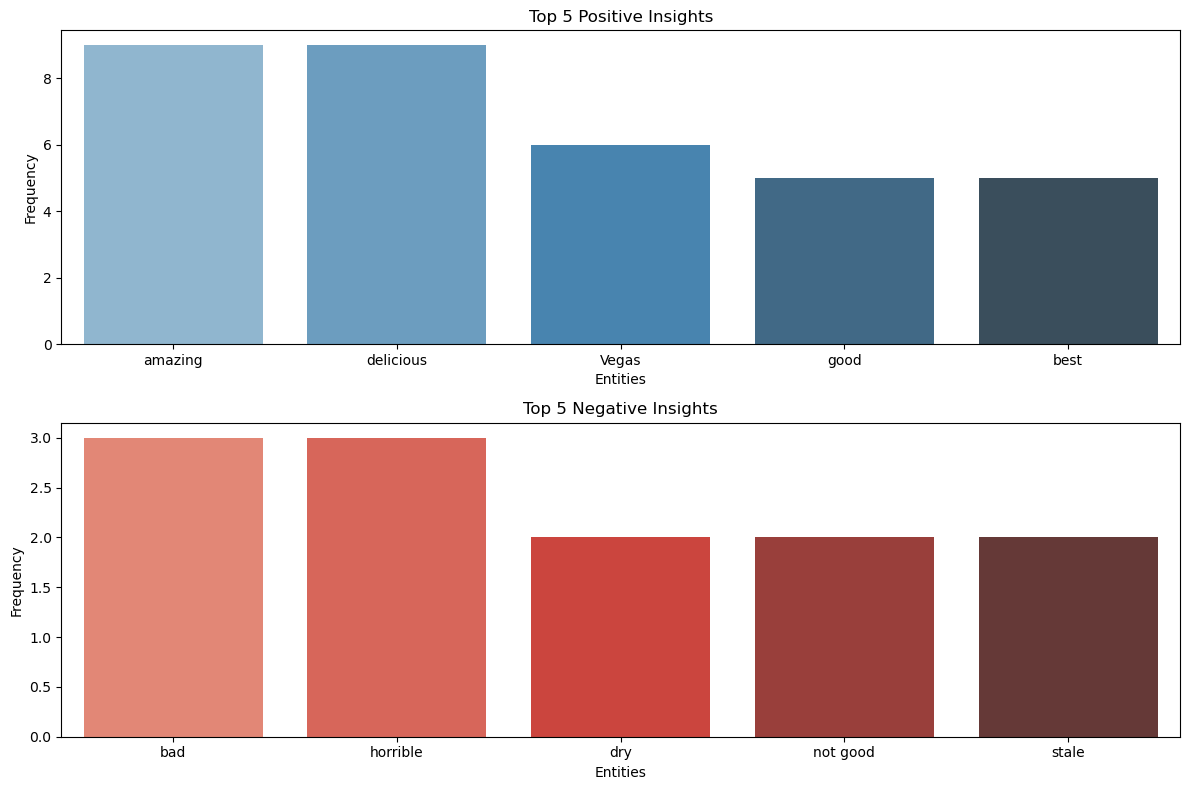

In [111]:
# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

sns.barplot(x=list(positive_entities), y=list(positive_counts), ax=axes[0], palette="Blues_d", hue=list(positive_entities), legend=False)
axes[0].set_title('Top 5 Positive Insights')
axes[0].set_xlabel('Entities')
axes[0].set_ylabel('Frequency')

sns.barplot(x=list(negative_entities), y=list(negative_counts), ax=axes[1], palette="Reds_d", hue=list(negative_entities), legend=False)
axes[1].set_title('Top 5 Negative Insights')
axes[1].set_xlabel('Entities')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Insights:**
The bar charts illustrate the most frequent positive and negative terms in the dataset.

1. Top 5 Positive Insights:
- "Amazing": Most frequent at 8 mentions, signaling high customer satisfaction.
- "Delicious": 7 mentions, highlighting food quality.
- "Vegas": 5 mentions, indicating positive associations.
- "Best" and "Friendly": 4 mentions each, reflecting top experiences and good service.

2. Top 5 Negative Insights:
- "Bad" and "Horrible": Each mentioned 3 times, common negative feedback.
- "Disappointed Entities": 3 mentions, showing frequent dissatisfaction.
- "Dry" and "Not good": 2 mentions each, indicating texture and general issues.

These insights shed light on the most common positive and negative sentiments expressed by customers, providing valuable information for improving customer experiences.


### Conclusion:

The custom Named Entity Recognition (NER) model exhibits strong capabilities in identifying and classifying entities from customer reviews. Detailed preprocessing, training, visualization, and evaluation highlight both its strengths and areas for improvement.
High Performance: The model excels in recognizing entities like FOOD, QUALITY, and STAFF, showing its reliability in these categories.
Moderate Performance: Entities such as PRICE, QUANTITY, and TIME are identified with decent accuracy, though there's room for improvement.
Low Performance: The model struggles with subjective entities like EMOTIONS, indicating a need for enhanced training data and more nuanced models.
Overall, the custom NER model shows great potential in extracting valuable insights from text data. There are clear pathways for enhancement, especially in handling more complex or nuanced entity types. This solid foundation supports impactful applications in sentiment analysis and other NLP tasks.